## Markov Chase: Detective vs. Fugitive in Three Cities

In [2]:
import numpy as np
import pandas as pd

# Define transition matrices for detective (P_D) and fugitive (P_F)
P_D = np.array([
    [0.2, 0.5, 0.3],
    [0.3, 0.3, 0.4],
    [0.1, 0.4, 0.5]
])

P_F = np.array([
    [0.3, 0.6, 0.1],
    [0.2, 0.4, 0.4],
    [0.3, 0.3, 0.4]
])

# Define cities and combined states
cities = ['A', 'B', 'C']
states = [(d, f) for d in cities for f in cities]
state_index = {state: idx for idx, state in enumerate(states)}

# Step 1: Construct the 9x9 transition matrix for the combined process
P = np.zeros((9, 9))
for i, (d1, f1) in enumerate(states):
    for j, (d2, f2) in enumerate(states):
        P[i, j] = P_D[cities.index(d1), cities.index(d2)] * P_F[cities.index(f1), cities.index(f2)]

# Step 2: Identify absorbing and transient states
absorbing_states = [i for i, (d, f) in enumerate(states) if d == f]
transient_states = [i for i in range(9) if i not in absorbing_states]

# Step 3: Rearrange transition matrix so absorbing states come first
new_order = absorbing_states + transient_states
P_reordered = P[np.ix_(new_order, new_order)]
P_reordered_df = pd.DataFrame(P_reordered, 
                              index=[states[i] for i in new_order], 
                              columns=[states[i] for i in new_order])

# Step 4: Extract submatrices Q and R
k = len(absorbing_states)
Q = P_reordered[k:, k:]
R = P_reordered[k:, :k]

# Step 5: Compute the fundamental matrix N = (I - Q)^-1
I = np.eye(len(Q))
N = np.linalg.inv(I - Q)

# Step 6: Compute expected time to absorption
t = N @ np.ones((len(Q), 1))

# Step 7: Compute absorption probabilities
B = N @ R

# Step 8: Results for initial state (A, B)
initial_state = state_index[('A', 'B')]
initial_state_reordered = new_order.index(initial_state) - k  # adjust for position in Q/B

expected_steps = t[initial_state_reordered, 0]
prob_meet_in_A = B[initial_state_reordered, absorbing_states.index(state_index[('A', 'A')])]

# Create DataFrames for each important result
Q_df = pd.DataFrame(Q, index=[states[i] for i in transient_states], columns=[states[i] for i in transient_states])
R_df = pd.DataFrame(R, index=[states[i] for i in transient_states], columns=[states[i] for i in absorbing_states])
N_df = pd.DataFrame(N, index=[states[i] for i in transient_states], columns=[states[i] for i in transient_states])
t_df = pd.DataFrame(t, index=[states[i] for i in transient_states], columns=["Expected Steps"])
B_df = pd.DataFrame(B, index=[states[i] for i in transient_states], columns=[states[i] for i in absorbing_states])

# Display results
print("Reordered Transition Matrix P:")
print(P_reordered_df.round(4), "\n")

print("Submatrix Q (Transient to Transient):")
print(Q_df.round(4), "\n")

print("Submatrix R (Transient to Absorbing):")
print(R_df.round(4), "\n")

print("Fundamental Matrix N:")
print(N_df.round(4), "\n")

print("Expected Steps to Absorption:")
print(t_df.round(4), "\n")

print("Absorption Probabilities:")
print(B_df.round(4), "\n")

print(f"Expected number of steps to capture (starting from A, B): {expected_steps:.4f}")
print(f"Probability that capture occurs in city A: {prob_meet_in_A:.4f}")

Reordered Transition Matrix P:
        (A, A)  (B, B)  (C, C)  (A, B)  (A, C)  (B, A)  (B, C)  (C, A)  (C, B)
(A, A)    0.06    0.30    0.03    0.12    0.02    0.15    0.05    0.09    0.18
(B, B)    0.06    0.12    0.16    0.12    0.12    0.06    0.12    0.08    0.16
(C, C)    0.03    0.12    0.20    0.03    0.04    0.12    0.16    0.15    0.15
(A, B)    0.04    0.20    0.12    0.08    0.08    0.10    0.20    0.06    0.12
(A, C)    0.06    0.15    0.12    0.06    0.08    0.15    0.20    0.09    0.09
(B, A)    0.09    0.18    0.04    0.18    0.03    0.09    0.03    0.12    0.24
(B, C)    0.09    0.09    0.16    0.09    0.12    0.09    0.12    0.12    0.12
(C, A)    0.03    0.24    0.05    0.06    0.01    0.12    0.04    0.15    0.30
(C, B)    0.02    0.16    0.20    0.04    0.04    0.08    0.16    0.10    0.20 

Submatrix Q (Transient to Transient):
        (A, B)  (A, C)  (B, A)  (B, C)  (C, A)  (C, B)
(A, B)    0.08    0.08    0.10    0.20    0.06    0.12
(A, C)    0.06    0.08    0.1

## Graph Visualization

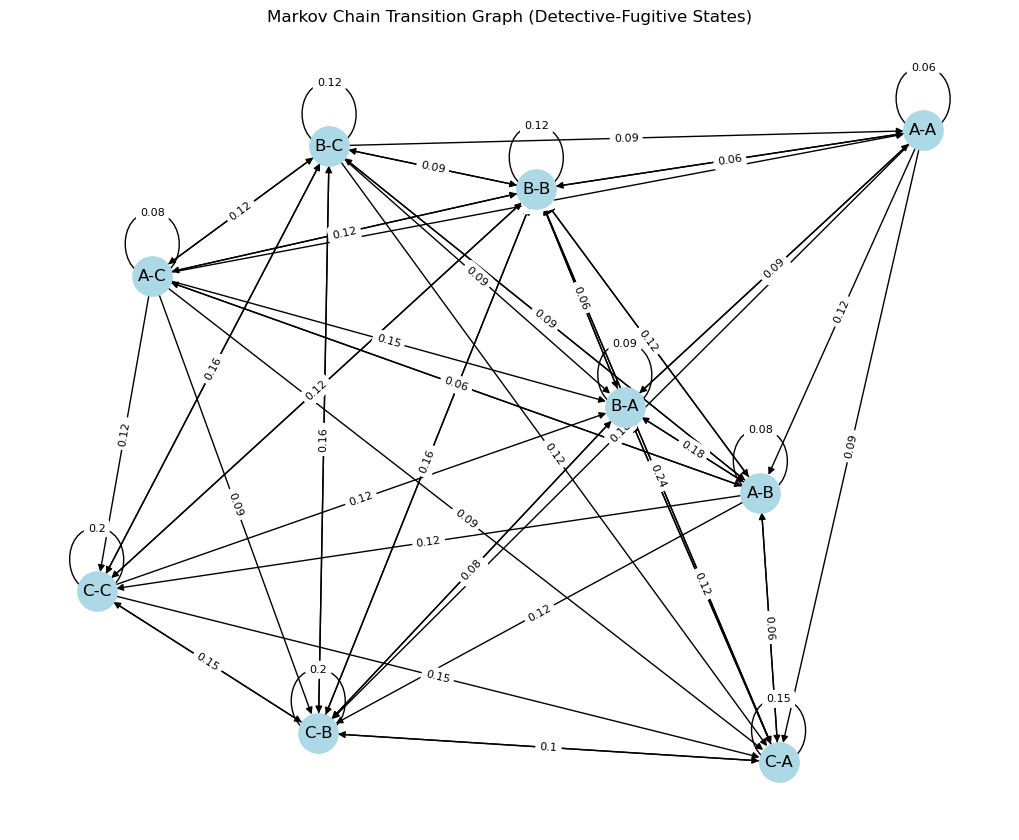

In [4]:
import networkx as nx
import matplotlib.pyplot as plt

# Create directed graph
G = nx.DiGraph()

# Add nodes with labels
for i, state in enumerate(states):
    G.add_node(i, label=f"{state[0]}-{state[1]}")

# Add edges with transition probabilities (only those with significant weight)
for i in range(9):
    for j in range(9):
        if P[i, j] > 0.05:  # threshold to reduce clutter
            G.add_edge(i, j, weight=round(P[i, j], 2))

# Layout and draw
pos = nx.spring_layout(G, seed=42)
edge_labels = nx.get_edge_attributes(G, 'weight')
node_labels = nx.get_node_attributes(G, 'label')

plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=800, node_color='lightblue', arrows=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.title("Markov Chain Transition Graph (Detective-Fugitive States)")
plt.axis('off')
plt.show()